In [1]:
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# ---------------------- Config ----------------------
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); tf.random.set_seed(RANDOM_SEED)

# Best params from your Optuna study
BEST = dict(
    lookback=3,
    d_model=128,
    num_heads=4,
    dff=512,
    num_layers=1,
    dropout=0.21995950332135625,
    lr=0.004490301282529978,
    batch_size=128,
    epochs=30,
    patience=8
)

# UQ settings
N_MC  = 100
ALPHA = 0.05          # 95% PI
USE_QUANTILES = True  # if False: Gaussian z*std

# Rolling/heatmap settings
ROLL_LEN   = 30
HEAT_WIN   = 30
HEAT_STRIDE= 10

In [3]:
# ---------------------- Load & prep ----------------------
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite",TARGET_COL
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL).ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


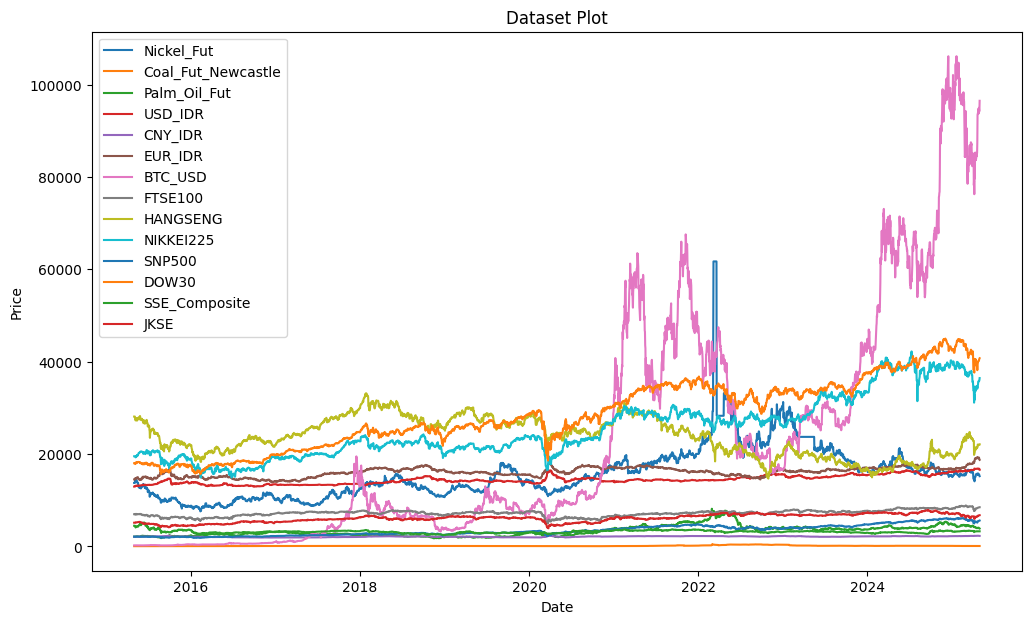

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [5]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

In [6]:
feature_cols = df.columns.tolist() if INCLUDE_TARGET_AS_FEATURE else [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [7]:
# scalers
X_scaler = StandardScaler().fit(train_df[feature_cols])
y_scaler = StandardScaler().fit(train_df[[TARGET_COL]])
y_mean, y_scale = float(y_scaler.mean_[0]), float(y_scaler.scale_[0])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values; y_vals = y_df.values.squeeze(); idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i]); idx_list.append(idx[i])
    return (np.array(X_list, np.float32),
            np.array(y_list, np.float32),
            np.array(idx_list))

X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST["lookback"])
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST["lookback"])
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST["lookback"])

In [8]:
# ---------------------- Transformer model ----------------------
class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs); self.d_model = d_model
    def call(self, x):
        L = tf.shape(x)[1]; d = self.d_model + (self.d_model % 2)
        pos = tf.cast(tf.range(L)[:, None], tf.float32)
        i   = tf.cast(tf.range(d)[None, :], tf.float32)
        angle_rates = 1.0 / tf.pow(10000.0, (2*(i//2))/d)
        angles = pos * angle_rates
        sines = tf.sin(angles[:, 0::2]); coses = tf.cos(angles[:, 1::2])
        pe = tf.concat([sines, coses], axis=-1)[:, :self.d_model]
        return x + pe[None, :, :]

def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn_out)])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)

    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer_model(lookback, n_features, d_model, num_heads, dff, num_layers, dropout, lr):
    inp = Input(shape=(lookback, n_features))
    x   = Dense(d_model)(inp)
    x   = SinusoidalPositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = encoder_block(x, num_heads=num_heads, d_model=d_model, dff=dff, dropout_rate=dropout)
    x   = Lambda(lambda t: t[:, -1, :])(x)        # last step pooling
    out = Dense(1)(x)
    m = Model(inputs=inp, outputs=out)
    m.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return m

model = build_transformer_model(
    lookback=BEST["lookback"], n_features=len(feature_cols),
    d_model=BEST["d_model"], num_heads=BEST["num_heads"],
    dff=BEST["dff"], num_layers=BEST["num_layers"],
    dropout=BEST["dropout"], lr=BEST["lr"]
)

In [9]:
# ---------------------- Train ----------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=BEST["patience"], restore_best_weights=True),
    ModelCheckpoint("transformer_mcdo_best.keras", monitor="val_loss", save_best_only=True)
]
print("\nTraining Transformer with fixed best hyperparams...")
t0 = time.time()
history = model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=BEST["epochs"],
    batch_size=BEST["batch_size"],
    callbacks=callbacks,
    verbose=1
)
print(f"Training time: {time.time()-t0:.2f}s")


Training Transformer with fixed best hyperparams...
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 15.7136 - val_loss: 0.8115
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3362 - val_loss: 0.3293
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2009 - val_loss: 0.5778
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1545 - val_loss: 0.6253
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1359 - val_loss: 0.7855
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1188 - val_loss: 0.6943
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1000 - val_loss: 0.9851
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0871 - val_loss: 1.1738
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0741 - val_loss: 1.3736
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0549 - val_loss: 1.3390
Training time: 26.67s


In [10]:
# ---------------------- Deterministic predictions ----------------------
def pred_det(m, X, idx):
    yhat_s = m.predict(X, verbose=0).squeeze()          # scaled
    yhat   = yhat_s * y_scale + y_mean                   # inverse
    return pd.Series(yhat, index=idx, name="Pred")

pred_train_det = pred_det(model, X_train_w, idx_train)
pred_val_det   = pred_det(model, X_val_w,   idx_val)
pred_test_det  = pred_det(model, X_test_w,  idx_test)

actual = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return dict(MSE=mse, MAE=mae, RMSE=rmse, MAPE=mape, R2=r2)

print("\n=== Point Forecast Metrics (deterministic forward) ===")
print("Train:", base_metrics(actual_train.values, pred_train_det.values))
print("Val:  ", base_metrics(actual_val.values,   pred_val_det.values))
print("Test: ", base_metrics(actual_test.values,  pred_test_det.values))


=== Point Forecast Metrics (deterministic forward) ===
Train: {'MSE': 41570.62068376033, 'MAE': 163.51601632720903, 'RMSE': 203.88874584871115, 'MAPE': 0.02864050001451453, 'R2': 0.8961587693148673}
Val:   {'MSE': 131743.4525336268, 'MAE': 321.27409977065406, 'RMSE': 362.9648089465793, 'MAPE': 0.04611963449341886, 'R2': -1.8401854798254935}
Test:  {'MSE': 446041.663424115, 'MAE': 600.7302974834079, 'RMSE': 667.8635065820822, 'MAPE': 0.0833654361529342, 'R2': -2.933966518032914}


In [11]:
# ---------------------- Monte-Carlo Dropout ----------------------
@tf.function
def mc_call(m, X, training=True):
    return m(X, training=training)  # keep Dropout active in encoder blocks

def predict_mc(m, X_np, idx, n_mc=N_MC, use_quantiles=USE_QUANTILES, alpha=ALPHA):
    Ys_scaled = []
    X_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
    for _ in range(n_mc):
        y_s = mc_call(m, X_tf, training=True).numpy().squeeze()   # (N,)
        Ys_scaled.append(y_s)
    Ys_scaled = np.stack(Ys_scaled, axis=1)  # (N, T)
    Ys = Ys_scaled * y_scale + y_mean        # inverse across all samples

    mean = Ys.mean(axis=1)
    std  = Ys.std(axis=1, ddof=1)
    if use_quantiles:
        lower = np.quantile(Ys, q=alpha/2, axis=1)
        upper = np.quantile(Ys, q=1-alpha/2, axis=1)
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2.0)
        lower, upper = mean - z*std, mean + z*std
    return (
        pd.Series(mean,  index=idx, name="mean"),
        pd.Series(lower, index=idx, name=f"lower_{int((1-alpha)*100)}"),
        pd.Series(upper, index=idx, name=f"upper_{int((1-alpha)*100)}"),
        pd.Series(std,   index=idx, name="mc_std"),
        Ys  # (N, T) real scale
    )

print("\nRunning MC Dropout...")
mean_train, L_train, U_train, std_train, Ys_train = predict_mc(model, X_train_w, idx_train)
mean_val,   L_val,   U_val,   std_val,   Ys_val   = predict_mc(model, X_val_w,   idx_val)
mean_test,  L_test,  U_test,  std_test,  Ys_test  = predict_mc(model, X_test_w,  idx_test)



Running MC Dropout...


In [12]:
# ---------------------- UQ metrics ----------------------
def uq_metrics(y_true, L, U, alpha=ALPHA):
    y = np.asarray(y_true); L = np.asarray(L); U = np.asarray(U)
    cover = (y >= L) & (y <= U)
    picp = cover.mean()
    mpiw = np.mean(U - L)
    penalty = np.where(y < L, (2/alpha)*(L - y),
              np.where(y > U, (2/alpha)*(y - U), 0.0))
    winkler = np.mean((U - L) + penalty)
    return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)

print(f"\n=== UQ Metrics ({int((1-ALPHA)*100)}% PI) ===")
print("Train:", uq_metrics(actual_train.values, L_train.values, U_train.values, ALPHA))
print("Val:  ", uq_metrics(actual_val.values,   L_val.values,   U_val.values,   ALPHA))
print("Test: ", uq_metrics(actual_test.values,  L_test.values,  U_test.values,  ALPHA))


=== UQ Metrics (95% PI) ===
Train: {'PICP': 0.9114249037227214, 'MPIW': 751.7757541720152, 'Winkler': 1049.8535437365617}
Val:   {'PICP': 0.35111876075731496, 'MPIW': 735.3820361244082, 'Winkler': 5593.934458731987}
Test:  {'PICP': 0.1279229711141678, 'MPIW': 737.2785943074599, 'Winkler': 15512.088687762805}


In [13]:
# ---------------------- Epistemic vs Aleatoric (approximation) ----------------------
# Aleatoric proxy from validation residual variance (no test leakage)
resid_val = actual_val.values - mean_val.values
sigma2_aleatoric = np.var(resid_val, ddof=1)
var_total_test   = np.var(Ys_test, axis=1, ddof=1)   # MC variance at each time step
var_epistemic    = np.maximum(0.0, var_total_test - sigma2_aleatoric)
var_aleatoric    = np.full_like(var_total_test, sigma2_aleatoric)

epi_series = pd.Series(var_epistemic, index=idx_test, name="var_epistemic")
ale_series = pd.Series(var_aleatoric, index=idx_test, name="var_aleatoric")
tot_series = pd.Series(var_total_test, index=idx_test, name="var_total")

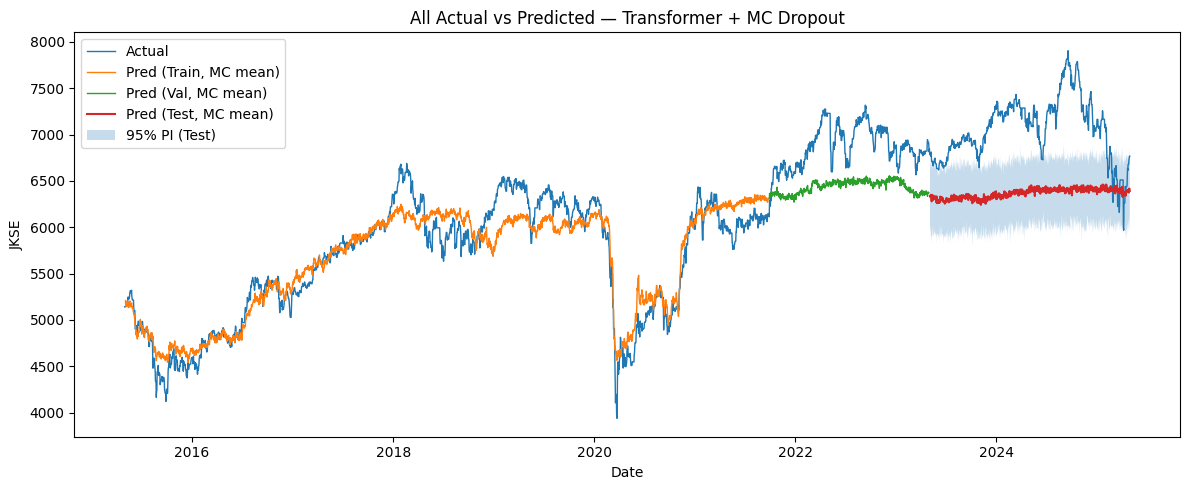

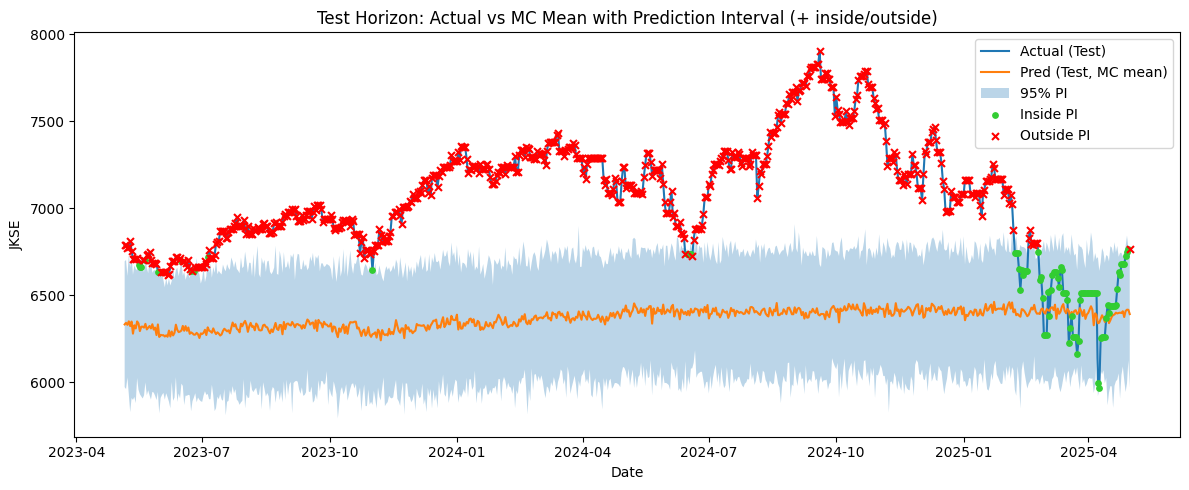

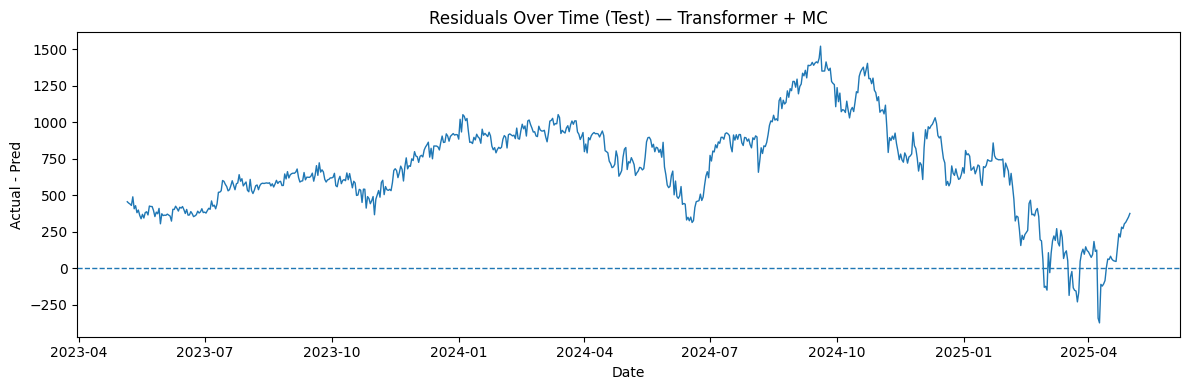

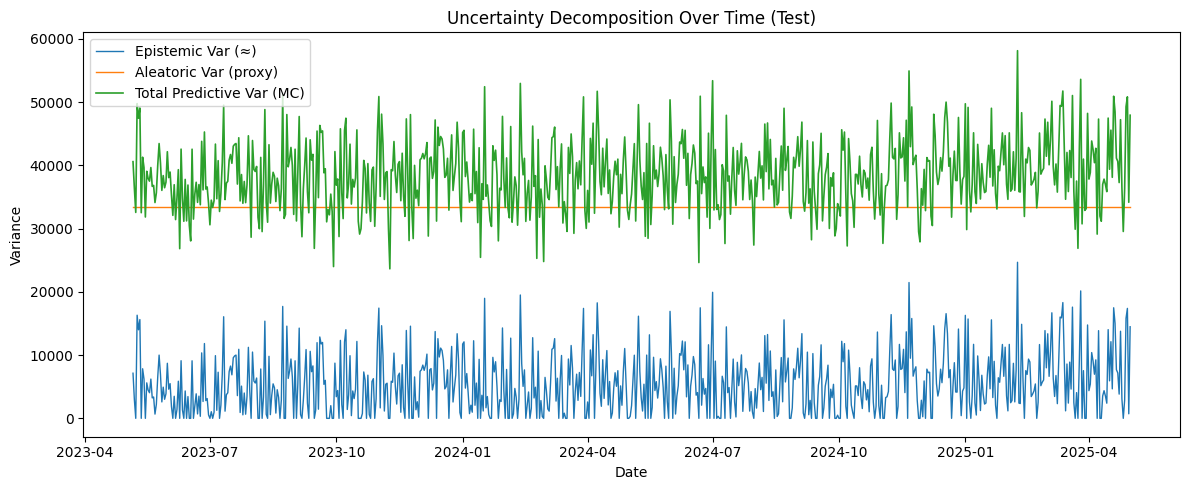

In [14]:
# ---------------------- Visualizations ----------------------
def classify_inside_outside(y_true_s, L_s, U_s):
    y = np.asarray(y_true_s); L = np.asarray(L_s); U = np.asarray(U_s)
    inside = (y >= L) & (y <= U)
    return inside, ~inside

# 1) Full series
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual", linewidth=1)
plt.plot(mean_train.index, mean_train.values, label="Pred (Train, MC mean)", linewidth=1)
plt.plot(mean_val.index,   mean_val.values,   label="Pred (Val, MC mean)", linewidth=1)
plt.plot(mean_test.index,  mean_test.values,  label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.25, label=f"{int((1-ALPHA)*100)}% PI (Test)")
plt.title("All Actual vs Predicted — Transformer + MC Dropout")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 2) Test horizon with inside/outside markers
inside_mask, outside_mask = classify_inside_outside(actual_test.values, L_test.values, U_test.values)
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mean_test.index,   mean_test.values,   label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.30, label=f"{int((1-ALPHA)*100)}% PI")
plt.scatter(actual_test.index[inside_mask],  actual_test.values[inside_mask],  s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(actual_test.index[outside_mask], actual_test.values[outside_mask], s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Test Horizon: Actual vs MC Mean with Prediction Interval (+ inside/outside)")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals (test)
residuals_test = pd.Series(actual_test.values - mean_test.values, index=actual_test.index, name="Residuals")
plt.figure(figsize=(12,4))
plt.plot(residuals_test.index, residuals_test.values, linewidth=1)
plt.axhline(0, ls="--", lw=1); plt.title("Residuals Over Time (Test) — Transformer + MC")
plt.xlabel("Date"); plt.ylabel("Actual - Pred"); plt.tight_layout(); plt.show()

# 4) Uncertainty decomposition
plt.figure(figsize=(12,5))
plt.plot(epi_series.index, epi_series.values, label="Epistemic Var (≈)", linewidth=1)
plt.plot(ale_series.index, ale_series.values, label="Aleatoric Var (proxy)", linewidth=1)
plt.plot(tot_series.index, tot_series.values, label="Total Predictive Var (MC)", linewidth=1.2)
plt.title("Uncertainty Decomposition Over Time (Test)")
plt.xlabel("Date"); plt.ylabel("Variance"); plt.legend(); plt.tight_layout(); plt.show()

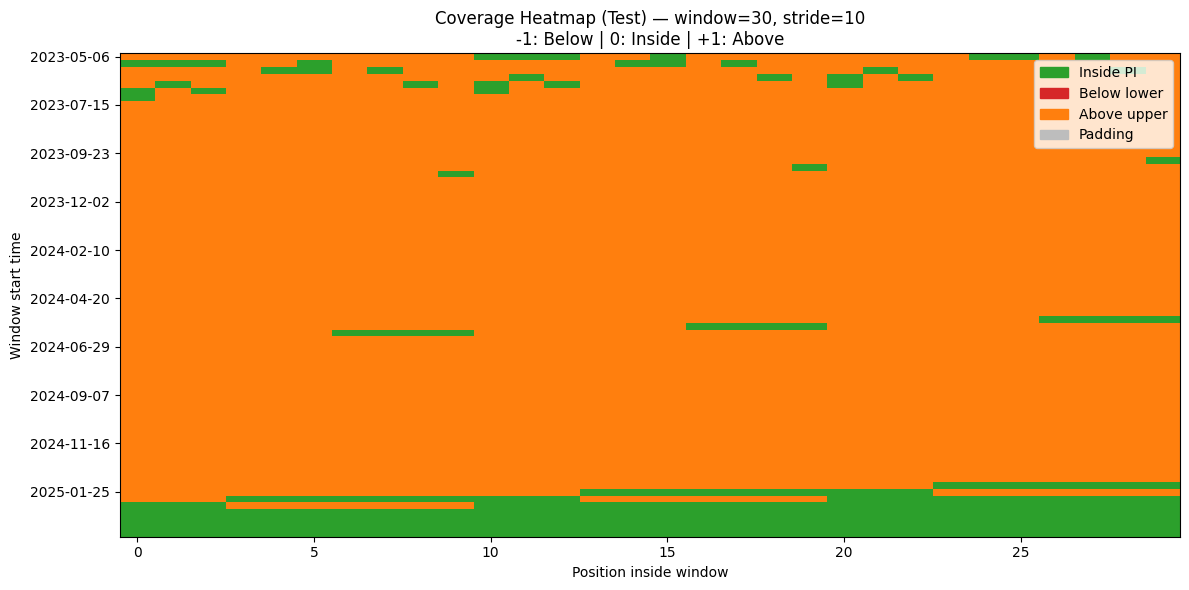

In [15]:
# ---------------------- (a) Coverage heatmap (per-window) ----------------------
from matplotlib.colors import ListedColormap, BoundaryNorm
y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
below_mask = (y_true < L_arr); above_mask = (y_true > U_arr); inside_mask = (y_true >= L_arr) & (y_true <= U_arr)
status = np.zeros_like(y_true, dtype=int); status[below_mask] = -1; status[above_mask] = 1
starts = np.arange(0, len(status)-HEAT_WIN+1, HEAT_STRIDE)
if len(starts) == 0: starts = np.array([0]); HEAT_WIN = len(status)
mat = []; x_tick_labels = []
for s in starts:
    e = min(s + HEAT_WIN, len(status)); row = status[s:e]
    if e - s < HEAT_WIN: row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row); x_tick_labels.append(actual_test.index[s].strftime('%Y-%m-%d'))
mat = np.vstack(mat)
cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])  # red, green, orange, grey
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]; norm = BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(12,6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window"); plt.ylabel("Window start time")
yticks = np.arange(0, len(starts), max(1, len(starts)//10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding")
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

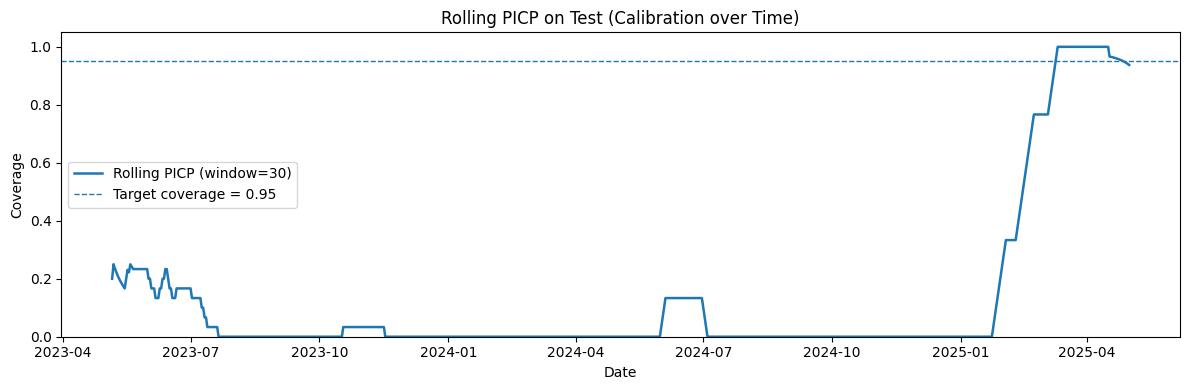

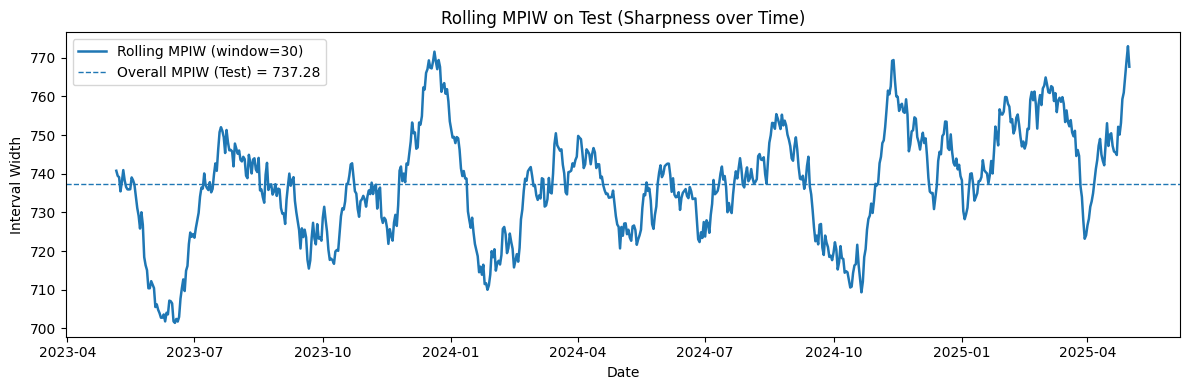

In [16]:
# ---------------------- (b) Rolling PICP & (c) Rolling MPIW ----------------------
inside_series = pd.Series(((y_true >= L_arr) & (y_true <= U_arr)).astype(int), index=actual_test.index, name="inside")
rolling_picp = inside_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label=f"Rolling PICP (window={ROLL_LEN})")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.ylim(0, 1.05); plt.title("Rolling PICP on Test (Calibration over Time)")
plt.xlabel("Date"); plt.ylabel("Coverage"); plt.legend(); plt.tight_layout(); plt.show()

width_series   = pd.Series((U_arr - L_arr), index=actual_test.index, name="PI_width")
rolling_mpiw   = width_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
overall_mpiw_t = width_series.mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, linewidth=1.8, label=f"Rolling MPIW (window={ROLL_LEN})")
plt.axhline(overall_mpiw_t, ls="--", lw=1, label=f"Overall MPIW (Test) = {overall_mpiw_t:.2f}")
plt.title("Rolling MPIW on Test (Sharpness over Time)")
plt.xlabel("Date"); plt.ylabel("Interval Width"); plt.legend(); plt.tight_layout(); plt.show()

In [17]:
# ---------------------- Compact summary table ----------------------
def table_metrics():
    def uq(y_true_s, L_s, U_s):
        y, L, U = y_true_s.values, L_s.values, U_s.values
        cover = (y >= L) & (y <= U)
        picp = cover.mean(); mpiw = np.mean(U - L)
        penalty = np.where(y < L, (2/ALPHA)*(L - y), np.where(y > U, (2/ALPHA)*(y - U), 0.0))
        winkler = np.mean((U - L) + penalty)
        return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)
    rows = []
    for tag, y_true_s, y_pred_s, L_s, U_s in [
        ("Train", actual_train, mean_train, L_train, U_train),
        ("Val",   actual_val,   mean_val,   L_val,   U_val),
        ("Test",  actual_test,  mean_test,  L_test,  U_test),
    ]:
        b = base_metrics(y_true_s.values, y_pred_s.values); u = uq(y_true_s, L_s, U_s)
        rows.append({"Split": tag, **{k: round(v,4) for k,v in b.items()},
                     "PICP": round(u["PICP"],4), "MPIW": round(u["MPIW"],4), "Winkler": round(u["Winkler"],4)})
    return pd.DataFrame(rows)

summary_df = table_metrics()
print("\n=== Summary (Point + UQ) — Transformer + MC Dropout ===")
print(summary_df.to_string(index=False))


=== Summary (Point + UQ) — Transformer + MC Dropout ===
Split         MSE      MAE     RMSE   MAPE      R2   PICP     MPIW    Winkler
Train  42941.7419 165.3393 207.2239 0.0291  0.8927 0.9114 751.7758  1049.8535
  Val 222765.1880 437.3046 471.9801 0.0630 -3.8025 0.3511 735.3820  5593.9345
 Test 587113.6068 702.4808 766.2334 0.0977 -4.1782 0.1279 737.2786 15512.0887


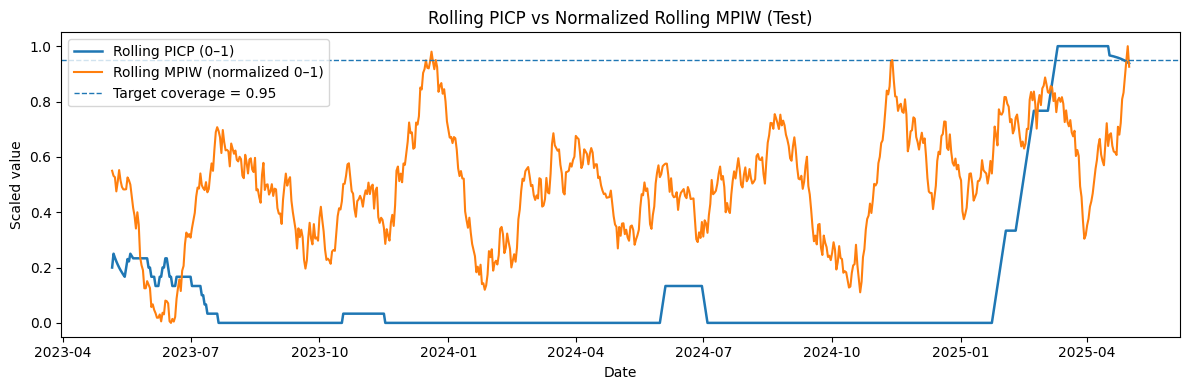

In [18]:
# (Optional) If you want a normalized comparison with Rolling PICP in a separate plot:
norm_mpiw = (rolling_mpiw - np.nanmin(rolling_mpiw)) / (np.nanmax(rolling_mpiw) - np.nanmin(rolling_mpiw) + 1e-12)
plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label="Rolling PICP (0–1)")
plt.plot(norm_mpiw.index, norm_mpiw.values, linewidth=1.5, label="Rolling MPIW (normalized 0–1)")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.title("Rolling PICP vs Normalized Rolling MPIW (Test)")
plt.xlabel("Date"); plt.ylabel("Scaled value")
plt.legend(); plt.tight_layout(); plt.show()